In [5]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
#from torch.autograd.gradcheck import zero_gradients
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2

In [6]:
#对比展现原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    import matplotlib.pyplot as plt
    plt.figure()

    #归一化
    if original_img.any() > 1.0:
        original_img=original_img/255.0
    if adversarial_img.any() > 1.0:
        adversarial_img=adversarial_img/255.0

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    #(-1,1)  -> (0,1)
    difference=difference / abs(difference).max()/2.0+0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
#获取计算设备 默认是CPU
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
image_path="../picture/test_im1.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = Variable(torch.from_numpy(img).to(device).float())
print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()

orig_label=np.argmax(model(img).data.cpu().numpy())
print("orig_label={}".format(orig_label))


torch.Size([1, 3, 224, 224])
orig_label=88


In [14]:
#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False

epochs=100
overshoot=0.02

#攻击目标
target_label=288
target=Variable(torch.Tensor([float(target_label)]).to(device).long())

input_shape = img.cpu().detach().numpy().shape
w = np.zeros(input_shape)
r_tot = np.zeros(input_shape)

loss_func = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):
    
    # forward 
    output = model(img)
    
    label=np.argmax(output.data.cpu().numpy())
    loss = loss_func(output, target)
    print("epoch={} label={} loss={}".format(epoch,label,loss))
    
    #如果定向攻击成功
    if label == target_label:
        break
   
    #梯度清零
    #zero_gradients(img)
    if img.grad is not None :
        img.grad.zero_()
    
    output[0, target_label].backward(retain_graph=True)
    w = img.grad.data.cpu().numpy().copy()

    f = output[0, target_label].data.cpu().numpy()

    pert = abs(f)/np.linalg.norm(w.flatten())

    # 计算 r_i 和 r_tot
    r_i =  (pert+1e-8) * w / np.linalg.norm(w)
        
    r_tot = np.float32(r_tot + r_i)
    
    img.data=img.data + (1+overshoot)*torch.from_numpy(r_tot).to(device)


epoch=0 label=88 loss=23.00044059753418
epoch=1 label=88 loss=19.914445877075195
epoch=2 label=88 loss=16.739351272583008
epoch=3 label=88 loss=14.715743064880371
epoch=4 label=88 loss=12.552579879760742
epoch=5 label=88 loss=10.390056610107422
epoch=6 label=88 loss=8.432774543762207
epoch=7 label=88 loss=6.093039512634277
epoch=8 label=288 loss=0.3813028335571289


(3, 224, 224)


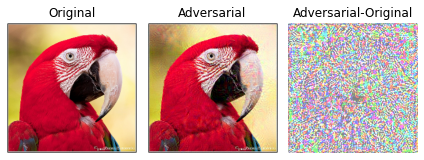

In [15]:
adv=img.data.cpu().numpy()[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
adv = np.clip(adv, 0, 255).astype(np.uint8)
%matplotlib inline
show_images_diff(orig,orig_label,adv,target_label)